Import needed libraries

In [1]:
from filters import DoGFilter
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

In [9]:
# Function to apply the filter to an image
def apply_filter(image, filter):
    # Convert image to torch tensor
    image_tensor = torch.tensor(image, dtype=torch.float32)
    
    # Apply the filter using convolution
    filter_size = filter.shape[0]
    padding = filter_size // 2
    image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    filter = filter.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    filtered_image = torch.nn.functional.conv2d(image_tensor, filter, padding=padding)
    
    return filtered_image.squeeze().numpy()

Load the Images

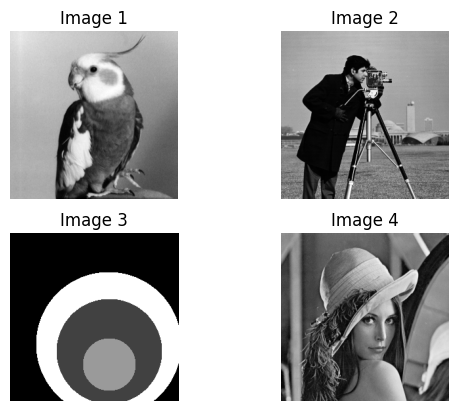

In [120]:
image1 = cv2.imread('images/bird.tif', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('images/camera.tif', cv2.IMREAD_GRAYSCALE)
image3 = cv2.imread('images/circles.tif', cv2.IMREAD_GRAYSCALE)
image4 = cv2.imread('images/lena1.tif', cv2.IMREAD_GRAYSCALE)
images = [image1, image2, image3, image4]

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.title(f'Image {i}')
    plt.imshow(images[i-1], cmap='gray')
    plt.axis('off')

Generate the DoG filter

In [164]:
on_center_dog_filter = DoGFilter(size=15, sigma_1=1.0, sigma_2=5.0, dtype=torch.float32)
off_center_dog_filter = DoGFilter(size=5, sigma_1=3.0, sigma_2=1.0, dtype=torch.float32)

Apply the DoG filter to the images

In [165]:
on_filtered_images = []
for i in range(1, 5):
    on_filtered_images.append(apply_filter(images[i-1], on_center_dog_filter))

off_filtered_images = []
for i in range(1, 5):
    off_filtered_images.append(apply_filter(images[i-1], off_center_dog_filter))

Display the results

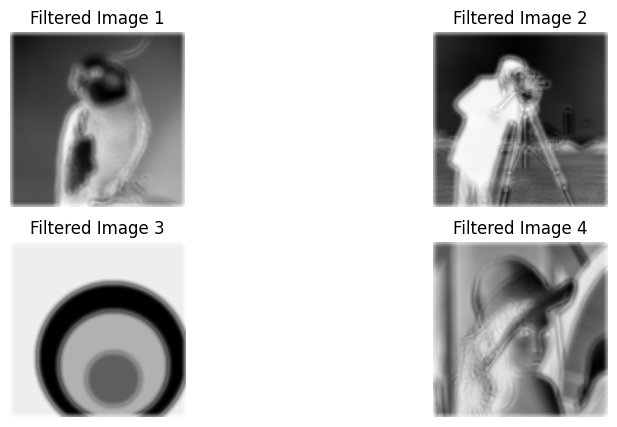

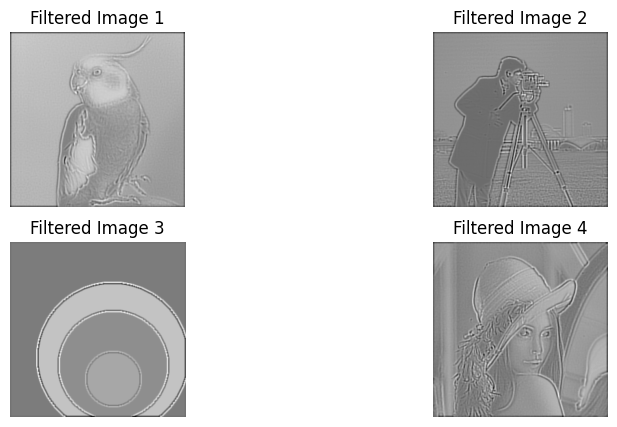

In [166]:
plt.figure(figsize=(10, 5))

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.title(f'Filtered Image {i}')
    plt.imshow(on_filtered_images[i-1], cmap='gray')
    plt.axis('off')

plt.show()

plt.figure(figsize=(10, 5))

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.title(f'Filtered Image {i}')
    plt.imshow(off_filtered_images[i-1], cmap='gray')
    plt.axis('off')

plt.show()